In [2]:
!pip install modAL

# Libraries
import os
import keras
import random
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

from PIL import Image
from IPython import display
from modAL.models import ActiveLearner
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical
from modAL.uncertainty import uncertainty_sampling
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras. layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [3]:
# Function to Create a Keras Model
def create_keras_model():
    
    # Initialize the Model
    model = Sequential()

    # Add Convolutional Layers
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    # Flatten the Feature Maps
    model.add(Flatten())

    # Add a Fully Connected Layer
    model.add(Dense(128, activation='relu'))

    # Add an Output Layer With a Single Node and Sigmoid Activation Function
    model.add(Dense(1, activation='sigmoid'))

    # Compile the Model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [4]:
# Classifier that will be Used for AL
classifier = KerasClassifier(create_keras_model)

In [5]:
# Directories
non_COVID = r'/kaggle/input/sarscov2-ctscan-dataset/non-COVID'
COVID = r'/kaggle/input/sarscov2-ctscan-dataset/COVID'

In [6]:
# Initialize Lists to Store the Images and Labels
images = []
labels = []

batch_size = 16

In [7]:
# Load the Images and Labels from the Non-COVID and COVID Directories
for image_dir, label in [(non_COVID, 0), (COVID, 1)]:
    filenames = os.listdir(image_dir)
    for filename in filenames:
        img = Image.open(os.path.join(image_dir, filename))
        img = img.convert('L')
        img = img.resize((128, 128))        
        img = np.array(img)
        # Normalization
        img = img / 255
        img = np.expand_dims(img, 2)
        images.append(img)
        labels.append(label)

In [8]:
# Convert the Images and Labels to Numpy Arrays
images = np.array(images)
labels = np.array(labels)

In [9]:
# Prints for Testing Purposes
print("Size of images Numpy Array:", len(images))
print("Shape of images Numpy Array:", images.shape)
print("Labels:", labels)

Size of images Numpy Array: 2481
Shape of images Numpy Array: (2481, 128, 128, 1)
Labels: [0 0 0 ... 1 1 1]


In [10]:
# Create X_train, X_val, X_test, Y_train, y_val, y_test
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [11]:
# Create the Train, Validation, and Test Datasets
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)

2023-01-18 14:12:45.225993: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-18 14:12:45.227062: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-18 14:12:45.360727: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-18 14:12:45.361693: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-18 14:12:45.362574: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [12]:
# Prints for Testing Purposes
print(f'Number of samples in each set (train, val, test): {len(X_train), len(X_val), len(X_test)}')
print(f'Number of positive samples in each set: {y_train.sum(), y_val.sum(), y_test.sum()}')
print("Number of positives:", y_train.sum() + y_val.sum() + y_test.sum())
print("Number of all samples:", len(X_train) + len(X_val) + len(X_test))
print("Number of all samples in the datasets:", len(train_ds) * 16 + len(val_ds) * 16 + len(test_ds) * 16)
print("Diff between all samples and dataset samples:", (len(train_ds) * 16 + len(val_ds) * 16 + len(test_ds) * 16) - (len(X_train) + len(X_val) + len(X_test)))

Number of samples in each set (train, val, test): (1587, 397, 497)
Number of positive samples in each set: (797, 196, 259)
Number of positives: 1252
Number of all samples: 2481
Number of all samples in the datasets: 2512
Diff between all samples and dataset samples: 31


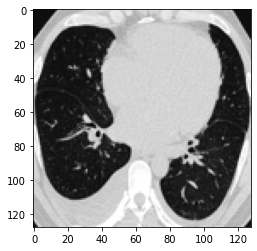

In [13]:
# Pick a Random Image from the Dataset
random_image = random.randint(0, len(images))

# Display the Image
plt.imshow(images[random_image], cmap='gray')
plt.show()

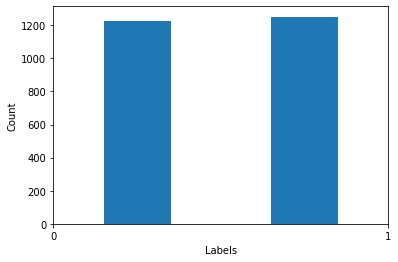

In [14]:
# Plot the Distribution of Labels
plt.hist(labels, bins=2, rwidth=0.4, range=(0, 1))
plt.xticks([0, 1])
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()

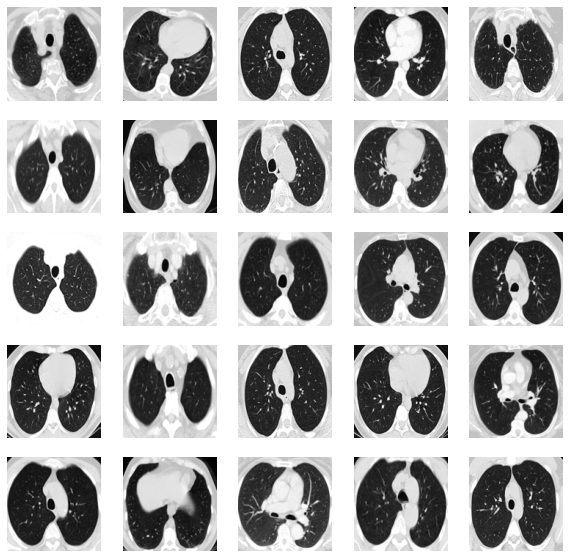

In [15]:
# Set the Number of Rows and Columns for the Subplots
rows = 5
cols = 5

# Create a Figure and Axes for the Subplots
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

# Flatten the Axes Array to Make it Easier to Iterate Over
axes = axes.ravel()

# Iterate Over the Images and Plot Each One
for i, img in enumerate(images[:25]):
    axes[i].imshow(img, cmap='gray')
    axes[i].axis('off')
    
plt.show()

In [16]:
# Split the Data into Initial Training Set, Pool, and Test Set
X_initial, X_pool, y_initial, y_pool = train_test_split(X_train, y_train, test_size=0.5)

In [17]:
# Prints for Testing Purposes
print("X_train:", len(X_train))
print("X_initial:", len(X_initial), "| Shape:", X_initial.shape)
print("y_initial:", len(y_initial), "| Shape:", y_initial.shape)
print("X_pool:", len(X_pool), "| Shape:", X_pool.shape)
print("y_pool:", len(y_pool), "| Shape:", y_pool.shape)

X_train: 1587
X_initial: 793 | Shape: (793, 128, 128, 1)
y_initial: 793 | Shape: (793,)
X_pool: 794 | Shape: (794, 128, 128, 1)
y_pool: 794 | Shape: (794,)


In [18]:
learner = ActiveLearner(
    estimator=classifier,
    query_strategy=uncertainty_sampling,
    X_training=X_initial, y_training=y_initial
)

2023-01-18 14:12:51.429147: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-01-18 14:12:53.297454: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


25/25 [==============================] - 10s 26ms/step - loss: 0.7253 - accuracy: 0.4880


In [19]:
X_training = X_initial.copy()
y_training = y_initial.copy()

# Empty List accuracy_scores Used to Store the Accuracy 
# of the Model at Each Iteration of the AL Loop
accuracy_scores = [learner.score(X_test, y_test)]

n_queries =  80

# Run for n_queries Number of Iterations 
for i in range(n_queries):
    # Selects an Instance from the Pool (X_pool) for Which the Model is Most Uncertain About
    query_idx, query_inst = learner.query(X_pool)
    print(query_idx)
#     with plt.style.context('seaborn-white'):
#         plt.figure(figsize=(10, 5))
#         # create two subplots side by side in the same figure, the first subplot is used to display the 
#         # image of the selected instance and the second subplot is used to display the accuracy of the model 
#         # over the number of iterations.
#         plt.subplot(1, 2, 1)
#         plt.title('Covid or Non-Covid')
#         plt.imshow(query_inst.reshape(128, 128))
#         plt.subplot(1, 2, 2)
#         plt.title('Accuracy of your model')
#         plt.plot(range(i+1), accuracy_scores)
#         plt.scatter(range(i+1), accuracy_scores)
#         plt.xlabel('number of queries')
#         plt.ylabel('accuracy')
#         # used to display the current figure on the screen
#         display(plt.gcf())
#         plt.close('all')

    print("Is this a covid or non-covid image? (1 for covid, 0 for non-covid)")
    y_new = y_pool[query_idx]
    learner.teach(query_inst, y_new)
    X_training = np.concatenate((X_training, query_inst), axis=0)
    y_training = np.concatenate((y_training, y_new), axis=0)
    X_pool, y_pool = np.delete(X_pool, query_idx, axis=0), np.delete(y_pool, query_idx, axis=0)
    accuracy_scores.append(learner.score(X_test, y_test))

16/16 [==============================] - 0s 13ms/step - loss: 0.6812 - accuracy: 0.5211
[463]
Is this a covid or non-covid image? (1 for covid, 0 for non-covid)
16/16 [==============================] - 0s 7ms/step - loss: 0.6884 - accuracy: 0.6016
[635]
Is this a covid or non-covid image? (1 for covid, 0 for non-covid)
16/16 [==============================] - 0s 7ms/step - loss: 0.6938 - accuracy: 0.5211
[468]
Is this a covid or non-covid image? (1 for covid, 0 for non-covid)
16/16 [==============================] - 0s 9ms/step - loss: 0.6895 - accuracy: 0.6881
[738]
Is this a covid or non-covid image? (1 for covid, 0 for non-covid)
16/16 [==============================] - 0s 7ms/step - loss: 0.6867 - accuracy: 0.5070
[205]
Is this a covid or non-covid image? (1 for covid, 0 for non-covid)
16/16 [==============================] - 0s 8ms/step - loss: 0.6714 - accuracy: 0.5352
[163]
Is this a covid or non-covid image? (1 for covid, 0 for non-covid)
16/16 [==============================] 

In [20]:
print("X_training:", len(X_training))
print("y_training:", len(y_training))
print("X_train:", len(X_train))
print("y_train:", len(y_train))
print("query_inst:", len(query_inst))
print("query_idx:", len(query_idx))
print("X_pool:", len(X_pool))
print("y_pool:", len(y_pool))
print("X_initial:", len(X_initial))
print("y_initial:", len(y_initial))
print("X_test:", len(X_test))
print("y_test:", len(y_test))

X_training: 873
y_training: 873
X_train: 1587
y_train: 1587
query_inst: 1
query_idx: 1
X_pool: 714
y_pool: 714
X_initial: 793
y_initial: 793
X_test: 497
y_test: 497


In [21]:
# Classifier Trained by the AL
history = classifier.fit(X_training, y_training, batch_size=32, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
28/28 [==============================] - 1s 26ms/step - loss: 0.6674 - accuracy: 0.5968 - val_loss: 0.8140 - val_accuracy: 0.5433
Epoch 2/10
28/28 [==============================] - 1s 21ms/step - loss: 0.5268 - accuracy: 0.7342 - val_loss: 0.5177 - val_accuracy: 0.7425
Epoch 3/10
28/28 [==============================] - 1s 25ms/step - loss: 0.4288 - accuracy: 0.8018 - val_loss: 0.4570 - val_accuracy: 0.7988
Epoch 4/10
28/28 [==============================] - 1s 22ms/step - loss: 0.3764 - accuracy: 0.8499 - val_loss: 0.4354 - val_accuracy: 0.7867
Epoch 5/10
28/28 [==============================] - 1s 21ms/step - loss: 0.3079 - accuracy: 0.8763 - val_loss: 0.3921 - val_accuracy: 0.8270
Epoch 6/10
28/28 [==============================] - 1s 22ms/step - loss: 0.2696 - accuracy: 0.8923 - val_loss: 0.3685 - val_accuracy: 0.8290
Epoch 7/10
28/28 [==============================] - 1s 23ms/step - loss: 0.2205 - accuracy: 0.9164 - val_loss: 0.3526 - val_accuracy: 0.8491
Epoch 8/10
28

In [22]:
y_pred = classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred) 
print("Accuracy:", accuracy)
print("precision:", precision)
print("recall:", recall)
print("f1:", f1)

Accuracy: 0.8651911468812877
precision: 0.8287671232876712
recall: 0.9343629343629344
f1: 0.8784029038112523


In [23]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.79      0.85       238
           1       0.83      0.93      0.88       259

    accuracy                           0.87       497
   macro avg       0.87      0.86      0.86       497
weighted avg       0.87      0.87      0.86       497



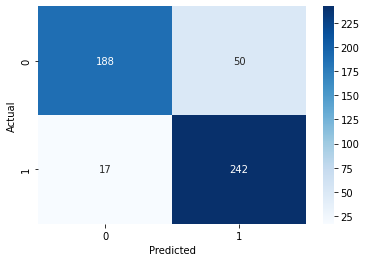

In [24]:
conf_mat = confusion_matrix(y_test, y_pred)

sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [25]:
# Print the Accuracy
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 86.52%


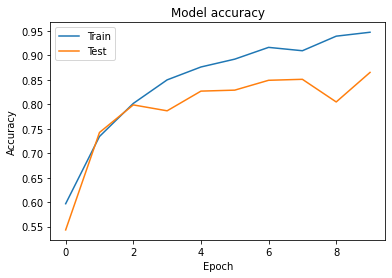

In [26]:
# Plot the Accuracy of the AL Classifier
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [27]:
# Classifier Trained by the CNN
classifier2 = KerasClassifier(create_keras_model)

In [28]:
history2 = classifier2.fit(X_training, y_training, batch_size=32, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
28/28 [==============================] - 1s 29ms/step - loss: 0.7183 - accuracy: 0.5407 - val_loss: 0.6658 - val_accuracy: 0.6479
Epoch 2/10
28/28 [==============================] - 1s 21ms/step - loss: 0.6023 - accuracy: 0.6541 - val_loss: 0.5511 - val_accuracy: 0.7324
Epoch 3/10
28/28 [==============================] - 1s 20ms/step - loss: 0.5248 - accuracy: 0.7583 - val_loss: 0.5619 - val_accuracy: 0.7143
Epoch 4/10
28/28 [==============================] - 1s 20ms/step - loss: 0.4575 - accuracy: 0.7938 - val_loss: 0.4927 - val_accuracy: 0.7726
Epoch 5/10
28/28 [==============================] - 1s 20ms/step - loss: 0.3911 - accuracy: 0.8362 - val_loss: 0.4534 - val_accuracy: 0.7746
Epoch 6/10
28/28 [==============================] - 1s 21ms/step - loss: 0.3300 - accuracy: 0.8625 - val_loss: 0.4538 - val_accuracy: 0.7867
Epoch 7/10
28/28 [==============================] - 1s 22ms/step - loss: 0.2826 - accuracy: 0.8912 - val_loss: 0.4026 - val_accuracy: 0.8390
Epoch 8/10
28

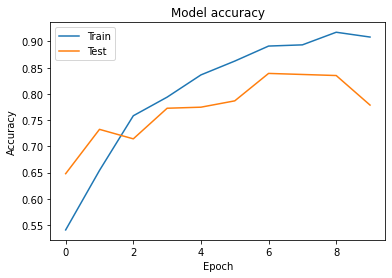

In [29]:
# Plot the Accuracy of the CNN Classifier
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [30]:
y_pred = classifier2.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred) 
print("Accuracy:", accuracy)
print("precision:", precision)
print("recall:", recall)
print("f1:", f1)

Accuracy: 0.778672032193159
precision: 0.8860103626943006
recall: 0.6602316602316602
f1: 0.756637168141593


In [31]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.91      0.80       238
           1       0.89      0.66      0.76       259

    accuracy                           0.78       497
   macro avg       0.80      0.78      0.78       497
weighted avg       0.80      0.78      0.78       497



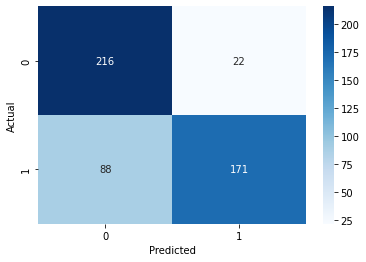

In [32]:
conf_mat = confusion_matrix(y_test, y_pred)

sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [33]:
# Print the Accuracy
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 77.87%


In [34]:
# Classifier Trained by the CNN
classifier3 = KerasClassifier(create_keras_model)

In [35]:
history3 = classifier3.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
50/50 [==============================] - 2s 22ms/step - loss: 0.6625 - accuracy: 0.5986 - val_loss: 0.5949 - val_accuracy: 0.6499
Epoch 2/10
50/50 [==============================] - 1s 19ms/step - loss: 0.5158 - accuracy: 0.7555 - val_loss: 0.5487 - val_accuracy: 0.7243
Epoch 3/10
50/50 [==============================] - 1s 19ms/step - loss: 0.5033 - accuracy: 0.7681 - val_loss: 0.4457 - val_accuracy: 0.7907
Epoch 4/10
50/50 [==============================] - 1s 19ms/step - loss: 0.3955 - accuracy: 0.8368 - val_loss: 0.4916 - val_accuracy: 0.7606
Epoch 5/10
50/50 [==============================] - 1s 19ms/step - loss: 0.3722 - accuracy: 0.8387 - val_loss: 0.3496 - val_accuracy: 0.8451
Epoch 6/10
50/50 [==============================] - 1s 19ms/step - loss: 0.2992 - accuracy: 0.8740 - val_loss: 0.3313 - val_accuracy: 0.8551
Epoch 7/10
50/50 [==============================] - 1s 19ms/step - loss: 0.2604 - accuracy: 0.8960 - val_loss: 0.2934 - val_accuracy: 0.8853
Epoch 8/10
50

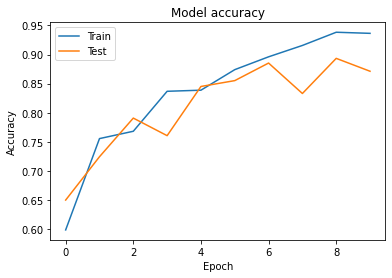

In [36]:
# Plot the Accuracy of the CNN Classifier
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [37]:
y_pred = classifier3.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred) 
print("Accuracy:", accuracy)
print("precision:", precision)
print("recall:", recall)
print("f1:", f1)

Accuracy: 0.8712273641851107
precision: 0.9148936170212766
recall: 0.8301158301158301
f1: 0.8704453441295547


In [38]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.92      0.87       238
           1       0.91      0.83      0.87       259

    accuracy                           0.87       497
   macro avg       0.87      0.87      0.87       497
weighted avg       0.88      0.87      0.87       497



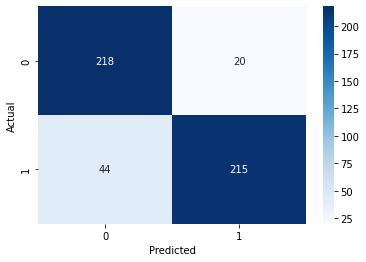

In [39]:
conf_mat = confusion_matrix(y_test, y_pred)

sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [40]:
# Print the Accuracy
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 87.12%


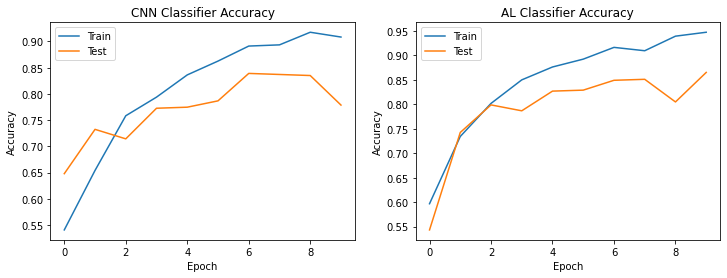

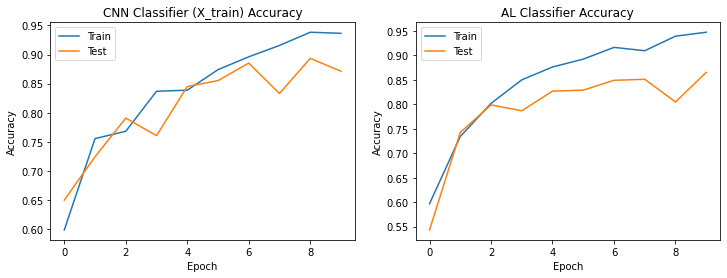

In [41]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

# CNN Classifier
ax1.plot(history2.history['accuracy'])
ax1.plot(history2.history['val_accuracy'])
ax1.set_title('CNN Classifier Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Test'], loc='upper left')

# AL Classifier
ax2.plot(history.history['accuracy'])
ax2.plot(history.history['val_accuracy'])
ax2.set_title('AL Classifier Accuracy')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Test'], loc='upper left')

plt.show()

fig, (ax3, ax2) = plt.subplots(1, 2, figsize=(12,4))

# CNN Classifier
ax3.plot(history3.history['accuracy'])
ax3.plot(history3.history['val_accuracy'])
ax3.set_title('CNN Classifier (X_train) Accuracy')
ax3.set_ylabel('Accuracy')
ax3.set_xlabel('Epoch')
ax3.legend(['Train', 'Test'], loc='upper left')

# AL Classifier
ax2.plot(history.history['accuracy'])
ax2.plot(history.history['val_accuracy'])
ax2.set_title('AL Classifier Accuracy')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Test'], loc='upper left')

plt.savefig('my_image.png')
plt.show()

In [42]:
# def predict_image(classifier, image_path):
#     # Load the image and resize it
#     img = Image.open(image_path)
#     img = img.convert('L')
#     img = img.resize((128, 128))
#     img = np.array(img)
#     img = img / 255
#     img = np.expand_dims(img, 2)
#     img = np.expand_dims(img, 0)

#     # Make a prediction using the classifier
#     prediction = classifier.predict(img)
#     if prediction[0][0] >= 0.5:
#         return 'Covid'
#     else:
#         return 'Non-Covid'

In [43]:
# imgs_array = []

# for i in range(1, 51):
#     image_path = r'C:\Users\karip\OneDrive\PC\Centre\University\Classes\Digital Processing of Biosignals\Assignments\COVID 19 Detection using AL and CNN\Dataset\Unlabeled\\' + f'Non-Covid ({i}).png' 
#     print(predict_image(classifier, image_path))

In [44]:
# for i in range(1, 51):
#     image_path = r'C:\Users\karip\OneDrive\PC\Centre\University\Classes\Digital Processing of Biosignals\Assignments\COVID 19 Detection using AL and CNN\Dataset\Unlabeled\\' + f'Covid ({i}).png' 
#     print(predict_image(classifier, image_path))